# protoufsock benchmarks

This experiment is not really about only Protobufs anymore. Instead, it compares the wire performance of WebSocket and WebTransport, using JSON, Protobuf or Messagepack encodings.

* to **take measurements**, start the Go server and the frontend:
  * `go run ./`
  * `cd frontend && yarn dev`
* edit `frontend/src/App.vue`
  * point the URLs to the Go server (e.g. if not on localhost)
  * insert the `certhash` from the server
* visit the HTTP server in the browser once, to accept selfsigned certificate
* open frontend at http://localhost:5173/
  * run a (short) benchmark with the button, to see if everything works
  * open the browser console (F12)
  * use `async benchmatrix(tuples: (count, noise)[], repetitions: number)` and wait
  * you'll get an object with the results, which you can right click and copy as JSON

For example, most of the measurements below were taken with:
```js
await benchmatrix([0, 256, 1024, 8192, 32768, 65536, 262144].map(n => [200, n]), 10)
```


This notebook serves to create plots from the measurements.

In [50]:
import json
import matplotlib.pyplot as plt

In [124]:
def render(filename, ylog = True):

    # load JSON data
    data = json.load(open(filename, "rt"))
    results = data['results']

    # Extract measurements and addNoise values
    noiseBytes = [result['addNoise'] for result in data['results']]
    ws_json_values = [result['ws+json'] for result in data['results']]
    ws_msgp_values = [result['ws+msgp'] for result in data['results']]
    ws_proto_values = [result['ws+proto'] for result in data['results']]
    wt_msgp_values = [result['wt+msgp'] for result in data['results']]
    wt_proto_values = [result['wt+proto'] for result in data['results']]

    # Group measurements by addNoise values
    grouped_data = {}
    for i, noise in enumerate(noiseBytes):
        if noise not in grouped_data:
            grouped_data[noise] = {
                'ws+json': [],
                'ws+msgp': [],
                'ws+proto': [],
                'wt+msgp': [],
                'wt+proto': [],
            }
        grouped_data[noise]['ws+json'].append(ws_json_values[i])
        grouped_data[noise]['ws+msgp'].append(ws_msgp_values[i])
        grouped_data[noise]['ws+proto'].append(ws_proto_values[i])
        grouped_data[noise]['wt+msgp'].append(wt_msgp_values[i])
        grouped_data[noise]['wt+proto'].append(wt_proto_values[i])

    # Prepare data for violin plots
    labels = list(grouped_data.keys())
    ws_json_violin = [grouped_data[noise]['ws+json'] for noise in labels]
    ws_msgp_violin = [grouped_data[noise]['ws+msgp'] for noise in labels]
    ws_proto_violin = [grouped_data[noise]['ws+proto'] for noise in labels]
    wt_msgp_violin = [grouped_data[noise]['wt+msgp'] for noise in labels]
    wt_proto_violin = [grouped_data[noise]['wt+proto'] for noise in labels]

    # Convert labels to strings
    labels = [str(noise) for noise in labels]

    # Create violin plots
    fig, ax = plt.subplots()

    width = 0.15
    x = np.arange(len(labels))

    violins = [
        ax.violinplot(ws_json_violin, positions=x-2*width, widths=width),
        ax.violinplot(ws_msgp_violin, positions=x-width, widths=width),
        ax.violinplot(ws_proto_violin, positions=x, widths=width),
        ax.violinplot(wt_msgp_violin, positions=x+width, widths=width),
        ax.violinplot(wt_proto_violin, positions=x+2*width, widths=width),
    ]

    # Add labels and title
    ax.set_xlabel('Random noise payload size')
    ax.set_ylabel('Measurements (log scale)')
    plt.suptitle('Network Protocol Benchmarks')
    ax.set_title(filename, size="small")
    ax.set_xticks(np.arange(len(labels)) - 0.5)
    ax.set_xticklabels(labels, ha="left")

    # Set y-axis to logarithmic scale
    if ylog: ax.set_yscale("log")
    # ax.set_ylim(100, 5000)
    ax.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
    ax.grid(axis='x', which='both', linestyle='--', linewidth=0.5)

    # Add legend
    import matplotlib.patches as mpatches
    protocols = ['WebSocket + JSON', 'WebSocket + MessagePack', 'WebSocket + Protobuf', 'WebTransport + MessagePack', 'WebTransport + Protobuf']
    colors = [v['bodies'][0].get_facecolor().flatten() for v in violins]
    labels = [(mpatches.Patch(color=colors[i]), protocols[i]) for i in range(5)]
    ax.legend(*zip(*labels), loc="upper left", fancybox=True, shadow=True, ncol=1)

    # Show the plot
    plt.show()


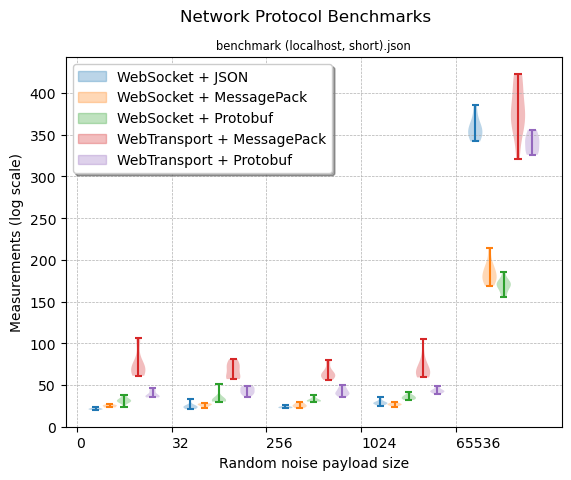

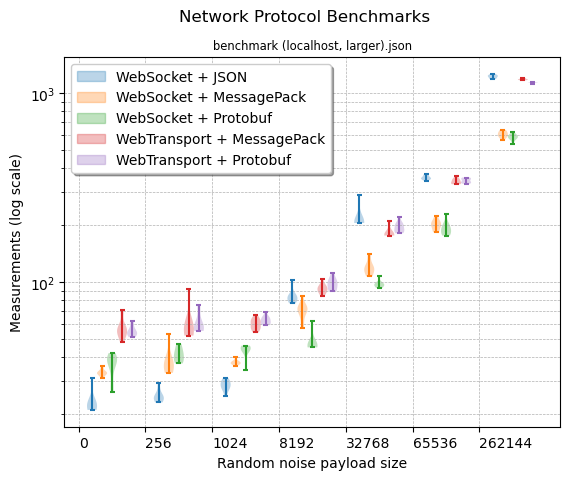

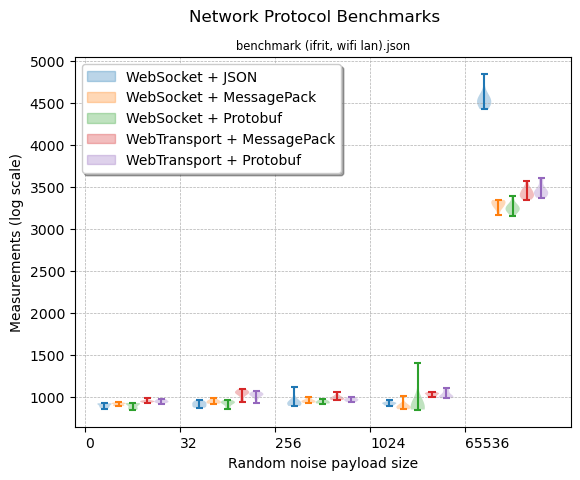

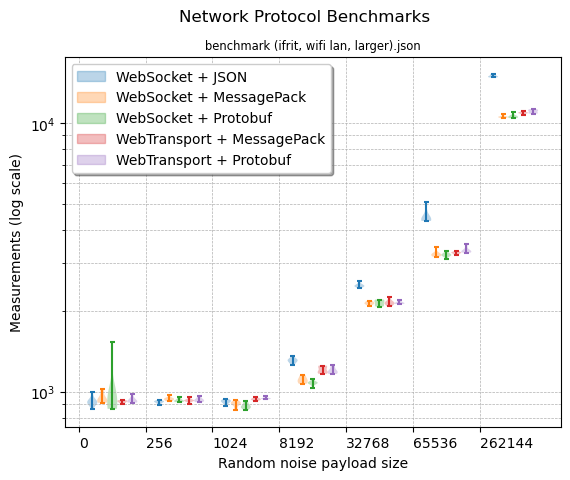

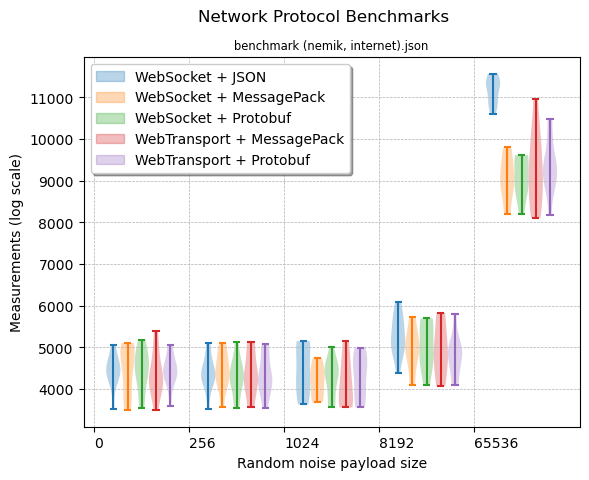

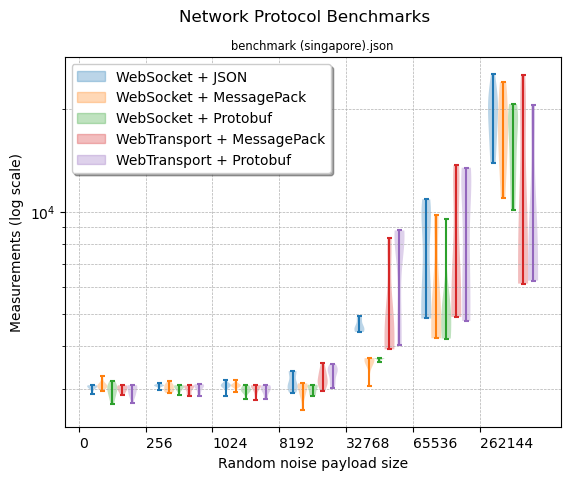

In [127]:
render("benchmark (localhost, short).json", ylog=False)
# render("benchmark (localhost, long).json", ylog=False)
render("benchmark (localhost, larger).json", ylog=True)
render("benchmark (ifrit, wifi lan).json", ylog=False)
render("benchmark (ifrit, wifi lan, larger).json", ylog=True)
render("benchmark (nemik, internet).json", ylog=False)
render("benchmark (singapore).json", ylog=True)